In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Clustering import Clustering
from DataNoiseAdder import DataNoiseAdder
from DatasetCorruptor import DatasetCorruptor
from DecisionTreeEnsemble import DecisionTreeEnsemble
from SyntheticDataGenerator import SyntheticDataGenerator
from EnsembleDiversity import EnsembleDiversity
from EnsembleMetrics import EnsembleMetrics

from utils import get_dataset, get_ensemble_preds_from_models, get_precision_recall_auc, auprc_threshs
from utils import plot_precision_recall, plot_aroc_at_curve, fitness_scatter
from utils import compute_metrics_in_buckets, flatten_df, compute_cluster_metrics

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

### Experiment Args

In [2]:
args = {}
args['ntrls'] = 10
args['ensemble_size'] = 10
args['dataset_path'] = "/Users/scottmerrill/Documents/UNC/Research/OOD-Ensembles/datasets"
args['dataset_name'] = 'heloc_tf' 

# Decision Tree/Model Pool Params
args['num_classifiers'] = 100
args['feature_fraction'] = 0.5
args['data_fraction'] = 0.8
args['max_depth'] = 10
args['min_samples_leaf'] = 5
args['random_state'] = 1
args['clusters_list'] = [3]

AUCTHRESHS = np.array([0.1, 0.2, 0.3, 0.4, 1. ])

In [3]:
x_train, y_train, x_val_id, y_val_id, x_val_ood, y_val_ood = get_dataset(args['dataset_path'] , args['dataset_name'])
num_features = x_train.shape[1]

### Building and Training Model Pool

In [4]:
model_pool = DecisionTreeEnsemble(args['num_classifiers'], 
                                  args['feature_fraction'],
                                  args['data_fraction'],
                                  args['max_depth'],
                                  args['min_samples_leaf'],
                                  args['random_state'])

# train model pool
model_pool.train(x_train, y_train)

### Caching Model Pool Predictions

In [5]:
model_pool_preds = model_pool.predict(x_val_ood)
model_pool_pred_probs = model_pool.predict_proba(x_val_ood)
mp_precision, mp_recall, mp_auc = get_precision_recall_auc(model_pool_pred_probs, y_val_ood, AUCTHRESHS)

### Caching Individual Model Predictions

In [6]:
model_pool.train_preds = model_pool.get_individual_predictions(x_train).T
model_pool.train_pred_probs = model_pool.get_individual_probabilities(x_train)

model_pool.val_id_preds = model_pool.get_individual_predictions(x_val_id).T
model_pool.val_id_pred_probs = model_pool.get_individual_probabilities(x_val_id)

model_pool.val_ood_preds = model_pool.get_individual_predictions(x_val_ood).T
model_pool.val_ood_pred_probs = model_pool.get_individual_probabilities(x_val_ood)

### Clustering Data into different groupings and preparing formating

In [7]:
clusters_dict = {}

clustering = Clustering(x_train)
for num_clusters in args['clusters_list']:
    kmean_labels = clustering.k_means(n_clusters=num_clusters)
    hier_labels = clustering.hierarchical_clustering(n_clusters=num_clusters)
    gmm_labels = clustering.gaussian_mixture(n_components=num_clusters)
    spectral_labels = clustering.spectral_clustering(n_clusters=num_clusters)
    clusters_dict[f'kmeans_{num_clusters}_train'] = kmean_labels
    clusters_dict[f'hier_{num_clusters}_train'] = hier_labels
    clusters_dict[f'gmm_{num_clusters}_train'] = gmm_labels
    clusters_dict[f'spectral_{num_clusters}_train'] = spectral_labels

clustering = Clustering(x_val_id)
for num_clusters in args['clusters_list']:
    kmean_labels = clustering.k_means(n_clusters=num_clusters)
    hier_labels = clustering.hierarchical_clustering(n_clusters=num_clusters)
    gmm_labels = clustering.gaussian_mixture(n_components=num_clusters)
    spectral_labels = clustering.spectral_clustering(n_clusters=num_clusters)
    clusters_dict[f'kmeans_{num_clusters}_val'] = kmean_labels
    clusters_dict[f'hier_{num_clusters}_val'] = hier_labels
    clusters_dict[f'gmm_{num_clusters}_val'] = gmm_labels
    clusters_dict[f'spectral_{num_clusters}_val'] = spectral_labels
    
    
dbscan_labels = clustering.dbscan()
mean_shift_labels = clustering.mean_shift()

dbscan_val_labels = clustering.dbscan()
mean_shift_val_labels = clustering.mean_shift()

clusters_dict[f'dbscan_train'] = dbscan_labels
clusters_dict[f'dbscan_val'] = mean_shift_val_labels
clusters_dict[f'meanshift_train'] = mean_shift_labels
clusters_dict[f'meanshift_val'] = mean_shift_val_labels

### Random Search Loop

In [8]:
precisions_df = pd.DataFrame()
recalls_df = pd.DataFrame()
aucs_df = pd.DataFrame()
fitness_df = pd.DataFrame()

for trial in tqdm(range(args['ntrls'])):
    indices = np.random.choice(model_pool.num_classifiers, size=args['ensemble_size'], replace=True)

    # id val preds of sub-ensemble
    train_preds, train_pred_probs = get_ensemble_preds_from_models(model_pool.train_pred_probs[indices])
    metrics_train = EnsembleMetrics(y_train, train_preds, train_pred_probs[:,1])
    diversity_train = EnsembleDiversity(y_train, model_pool.train_preds[indices])
    
    # id val preds of sub-ensemble
    id_preds, id_pred_probs = get_ensemble_preds_from_models(model_pool.val_id_pred_probs[indices])
    metrics_val = EnsembleMetrics(y_val_id, id_preds, id_pred_probs[:,1])
    diversity_val = EnsembleDiversity(y_val_id, model_pool.val_id_preds[indices])

    # ood preds of sub-ensemble
    ood_preds, ood_pred_probs = get_ensemble_preds_from_models(model_pool.val_ood_pred_probs[indices])

    
    # save dfs
    precision, recall, auc = get_precision_recall_auc(ood_pred_probs, y_val_ood, AUCTHRESHS)

    recalls_df = pd.concat([recalls_df, pd.DataFrame(recall)], axis=1)
    precisions_df = pd.concat([precisions_df, pd.DataFrame(precision)], axis=1)
    aucs_df = pd.concat([aucs_df, pd.DataFrame(auc)], axis=1)

    
    tmp = {'generation':trial,
          'ensemble_files':','.join(str(x) for x in indices),
           # train metrics
           'train_acc':metrics_train.accuracy(),
           'train_auc':metrics_train.auc(),
           'train_prec':metrics_train.precision(),
           'train_rec':metrics_train.recall(),
           'train_f1':metrics_train.f1(),
           'train_mae':metrics_train.mean_absolute_error(),
           'train_mse':metrics_train.mean_squared_error(),
           'train_logloss':metrics_train.log_loss(),
           
           # val metrics
          'val_acc':metrics_val.accuracy(),
           'val_auc':metrics_val.auc(),
           'val_prec':metrics_val.precision(),
           'val_rec':metrics_val.recall(),
           'val_f1':metrics_val.f1(),
           'val_mae':metrics_val.mean_absolute_error(),
           'val_mse':metrics_val.mean_squared_error(),
           'val_logloss':metrics_val.log_loss(),
          
           # train diversity
           'train_q_statistic':np.mean(diversity_train.q_statistic()),
           'train_correlation_coefficient':np.mean(diversity_train.correlation_coefficient()),
           'train_entropy':np.mean(diversity_train.entropy()),
           'train_diversity_measure':diversity_train.diversity_measure(),
           'train_hamming_distance':np.mean(diversity_train.hamming_distance()),
           'train_error_rate':np.mean(diversity_train.error_rate()),
           'train_auc':np.mean(diversity_train.auc()),
           'train_brier_score':np.mean(diversity_train.brier_score()),
           'train_ensemble_variance':np.mean(diversity_train.ensemble_variance()),

           'val_q_statistic':np.mean(diversity_val.q_statistic()),
           'val_correlation_coefficient':np.mean(diversity_val.correlation_coefficient()),
           'val_entropy':np.mean(diversity_val.entropy()),
           'val_diversity_measure':diversity_val.diversity_measure(),
           'val_hamming_distance':np.mean(diversity_val.hamming_distance()),
           'val_error_rate':np.mean(diversity_val.error_rate()),
           'val_auc':np.mean(diversity_val.auc()),
           'val_brier_score':np.mean(diversity_val.brier_score()),
           'val_ensemble_variance':np.mean(diversity_val.ensemble_variance()),

          }
    raw_metrics = pd.DataFrame([tmp])    
    cluster_metrics = compute_cluster_metrics(clusters_dict, y_train, train_preds, train_pred_probs, y_val_id, id_preds, id_pred_probs,
                                             model_pool.train_preds[indices], model_pool.val_id_preds[indices]) 
    tmp = pd.concat([raw_metrics, cluster_metrics], axis=1)
    fitness_df = pd.concat([fitness_df, tmp])
    #precisions_df.to_csv(save_path+'/precisions_df.csv', index=False)
    #recalls_df.to_csv(save_path+'/recalls_df.csv', index=False)
    #aucs_df.to_csv(save_path+'/aucs_df.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

### Plot Results

In [9]:
fitness_df = fitness_df.reset_index(drop=True)
best_fitness_index = {i+1:index for i,index in enumerate(fitness_df.nlargest(3, 'meanshift_val_log_loss_max').index)}

<Axes: title={'center': 'AUC@Recall (Gray are Random)'}, xlabel='T', ylabel='AUPRC@Recall<=T'>

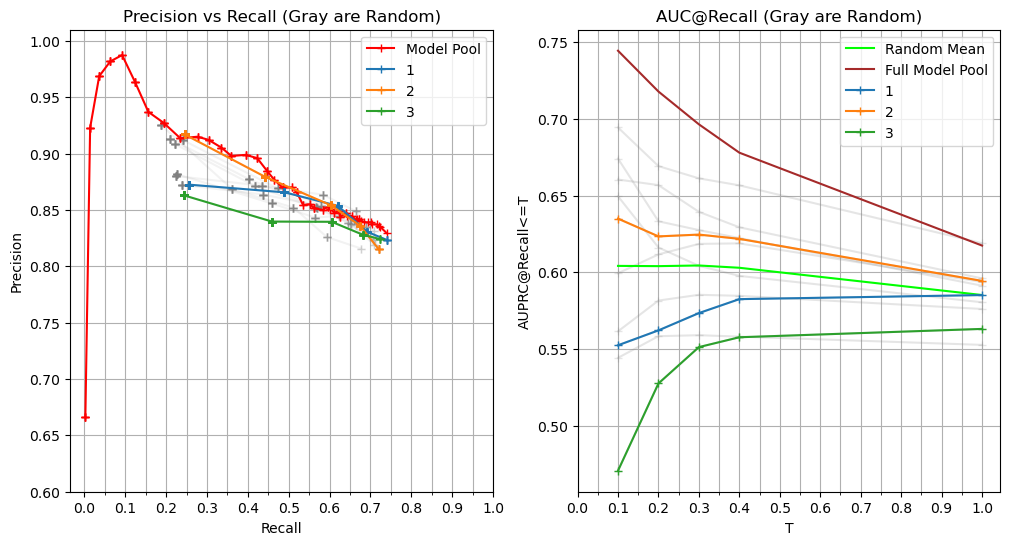

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_precision_recall(precisions_df, recalls_df, mp_precision, mp_recall, best_fitness_index, ax=axs[0])
plot_aroc_at_curve(AUCTHRESHS, aucs_df, mp_auc, best_fitness_index, ax=axs[1])

### Fitness Function Diagnosis


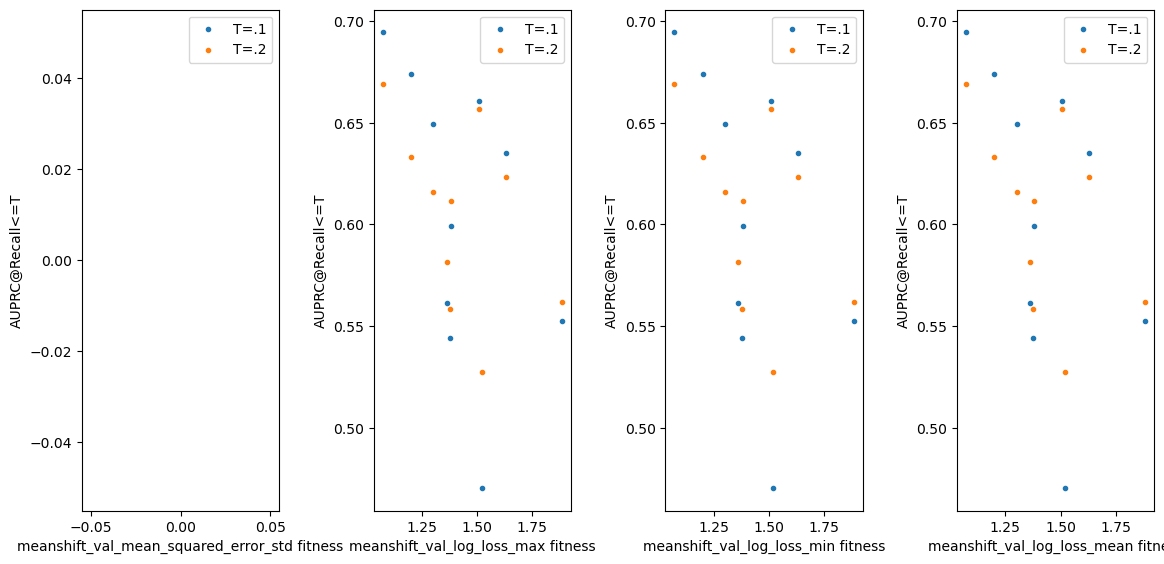

In [11]:
cols = ['meanshift_val_mean_squared_error_std', 'meanshift_val_log_loss_max', 'meanshift_val_log_loss_min', 'meanshift_val_log_loss_mean']
fig, axs = plt.subplots(1, len(cols), figsize=(12, 6))

for idx, col in enumerate(cols):
    # Plot AUC scatter for different fitness columns
    fitness_scatter(fitness_df, aucs_df, col, ax=axs[idx])
plt.tight_layout(pad=2)

In [17]:
pd.set_option('display.max_columns',None)
fitness_df.head()

,generation,ensemble_files,train_acc,train_auc,train_prec,train_rec,train_f1,train_mae,train_mse,train_logloss,val_acc,val_auc,val_prec,val_rec,val_f1,val_mae,val_mse,val_logloss,train_q_statistic,train_correlation_coefficient,train_entropy,train_diversity_measure,train_hamming_distance,train_error_rate,train_brier_score,train_ensemble_variance,val_q_statistic,val_correlation_coefficient,val_entropy,val_diversity_measure,val_hamming_distance,val_error_rate,val_brier_score,val_ensemble_variance,kmeans_3_train_accuracy_max,kmeans_3_train_accuracy_min,kmeans_3_train_accuracy_mean,kmeans_3_train_accuracy_std,kmeans_3_train_precision_max,kmeans_3_train_precision_min,kmeans_3_train_precision_mean,kmeans_3_train_precision_std,kmeans_3_train_recall_max,kmeans_3_train_recall_min,kmeans_3_train_recall_mean,kmeans_3_train_recall_std,kmeans_3_train_f1_max,kmeans_3_train_f1_min,kmeans_3_train_f1_mean,kmeans_3_train_f1_std,kmeans_3_train_auc_max,kmeans_3_train_auc_min,kmeans_3_train_auc_mean,kmeans_3_train_auc_std,kmeans_3_train_mean_absolute_error_max,kmeans_3_train_mean_absolute_error_min,kmeans_3_train_mean_absolute_error_mean,kmeans_3_train_mean_absolute_error_std,kmeans_3_train_mean_squared_error_max,kmeans_3_train_mean_squared_error_min,kmeans_3_train_mean_squared_error_mean,kmeans_3_train_mean_squared_error_std,kmeans_3_train_log_loss_max,kmeans_3_train_log_loss_min,kmeans_3_train_log_loss_mean,kmeans_3_train_log_loss_std,kmeans_3_train_q_statistic_max,kmeans_3_train_q_statistic_min,kmeans_3_train_q_statistic_mean,kmeans_3_train_q_statistic_std,kmeans_3_train_correlation_coefficient_max,kmeans_3_train_correlation_coefficient_min,kmeans_3_train_correlation_coefficient_mean,kmeans_3_train_correlation_coefficient_std,kmeans_3_train_entropy_max,kmeans_3_train_entropy_min,kmeans_3_train_entropy_mean,kmeans_3_train_entropy_std,kmeans_3_train_diversity_measure_max,kmeans_3_train_diversity_measure_min,kmeans_3_train_diversity_measure_mean,kmeans_3_train_diversity_measure_std,kmeans_3_train_hamming_distance_max,kmeans_3_train_hamming_distance_min,kmeans_3_train_hamming_distance_mean,kmeans_3_train_hamming_distance_std,kmeans_3_train_error_rate_max,kmeans_3_train_error_rate_min,kmeans_3_train_error_rate_mean,kmeans_3_train_error_rate_std,kmeans_3_train_brier_score_max,kmeans_3_train_brier_score_min,kmeans_3_train_brier_score_mean,kmeans_3_train_brier_score_std,kmeans_3_train_ensemble_variance_max,kmeans_3_train_ensemble_variance_min,kmeans_3_train_ensemble_variance_mean,kmeans_3_train_ensemble_variance_std,hier_3_train_accuracy_max,hier_3_train_accuracy_min,hier_3_train_accuracy_mean,hier_3_train_accuracy_std,hier_3_train_precision_max,hier_3_train_precision_min,hier_3_train_precision_mean,hier_3_train_precision_std,hier_3_train_recall_max,hier_3_train_recall_min,hier_3_train_recall_mean,hier_3_train_recall_std,hier_3_train_f1_max,hier_3_train_f1_min,hier_3_train_f1_mean,hier_3_train_f1_std,hier_3_train_auc_max,hier_3_train_auc_min,hier_3_train_auc_mean,hier_3_train_auc_std,hier_3_train_mean_absolute_error_max,hier_3_train_mean_absolute_error_min,hier_3_train_mean_absolute_error_mean,hier_3_train_mean_absolute_error_std,hier_3_train_mean_squared_error_max,hier_3_train_mean_squared_error_min,hier_3_train_mean_squared_error_mean,hier_3_train_mean_squared_error_std,hier_3_train_log_loss_max,hier_3_train_log_loss_min,hier_3_train_log_loss_mean,hier_3_train_log_loss_std,hier_3_train_q_statistic_max,hier_3_train_q_statistic_min,hier_3_train_q_statistic_mean,hier_3_train_q_statistic_std,hier_3_train_correlation_coefficient_max,hier_3_train_correlation_coefficient_min,hier_3_train_correlation_coefficient_mean,hier_3_train_correlation_coefficient_std,hier_3_train_entropy_max,hier_3_train_entropy_min,hier_3_train_entropy_mean,hier_3_train_entropy_std,hier_3_train_diversity_measure_max,hier_3_train_diversity_measure_min,hier_3_train_diversity_measure_mean,hier_3_train_diversity_measure_std,hier_3_train_hamming_distance_max,hier_3_train_hamming_distance_m